<a href="https://colab.research.google.com/github/oskrplopez81/DCDP_2022/blob/main/Reto1_reducci%C3%B3n_Ender_Decoder_y_Reg_Log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
 #trabajar con arrays y dataframes
import numpy as np
import pandas as pd
# crear mis capas densas
from keras.models import Model
from keras.layers import Input, Dense
#monitorear que no existe sobreajuste , es decir que mi modelo generalize bien.
from keras.callbacks import EarlyStopping
# Optimizador para ajustar pesos de mi red neuronal con el objetivo de minimizar la función de pérdida.
from keras.optimizers import Adam
#Evitar sobreajuste, apaga un % de neuronas
from keras.layers import Dropout
#Escalador, modelo ML ,split y matriz de confusion
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Diplomado Bourbaki DL2/reto1.csv")

In [4]:
df.head(3)

,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,1299,649.5,1299,0,1
1,195,0,0,0,0,0,0,0,0,0,...,0,0,0,3,3,4119,1373.0,2470,0,1
2,217,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2806,1403.0,2799,7,1


In [5]:
df_f=df.copy()
df_fX=df_f.drop(columns=['ID', 'fraud_flag'])
df_fY=df_f['fraud_flag']

In [6]:
df_fX.shape

(9319, 2455)

In [7]:
df_fX = df_fX.astype(float)

#scaler = StandardScaler() # datos normalizados
scaler = MinMaxScaler() # datos entre 0 a 1
df_fX_scaled = scaler.fit_transform(df_fX)

In [8]:
print(type(df_fX_scaled))
print(len(df_fX_scaled[1]))
print(df_fX_scaled.shape)

<class 'numpy.ndarray'>
2455
(9319, 2455)


## ¿Por que uso Sigmoide y no Relu en decoder_output?
Por que las variables las tengo entre 0 y 1, y Relu permite valores de [0,inf), y podemos caer en un rango fuera del 1,
Sigmoide va de 0 a 1, esto permite que mi modelo generalize correctamente.

In [9]:
input_dim = df_fX_scaled.shape[1]
encoding_dim = 25

#Capa de entrada
input_layer = Input(shape=(input_dim,))
# Codificador: Reduce la dimensionalidad
encoder = Dense(1024, activation="relu")(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(512, activation="relu")(encoder)
encoder = Dropout(0.2)(encoder)
encoder = Dense(256, activation="relu")(encoder)
encoder_output = Dense(encoding_dim, activation="relu")(encoder)

# Decodificador: Reconstruye los datos originales
decoder = Dense(256, activation="relu")(encoder_output)
decoder = Dropout(0.2)(decoder)
decoder = Dense(512, activation="relu")(decoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(1024, activation="relu")(decoder)
#modificar a Relu en el decoder_output
decoder_output = Dense(input_dim, activation="sigmoid")(decoder)
#decoder_output = Dense(input_dim, activation="relu")(decoder)

# Modelo de Autoencoder completo
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

#tasa de aprendizaje
optimizer = Adam(learning_rate=0.00001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
#autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(df_fX_scaled, df_fX_scaled,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping])

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 290ms/step - loss: 0.2498 - val_loss: 0.2496
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - loss: 0.2495 - val_loss: 0.2490
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - loss: 0.2485 - val_loss: 0.2455
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 0.2422 - val_loss: 0.2226
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 0.2052 - val_loss: 0.1249
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 0.0917 - val_loss: 0.0220
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - loss: 0.0154 - val_loss: 0.0049
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0012 - val_loss: 8.8103e-04


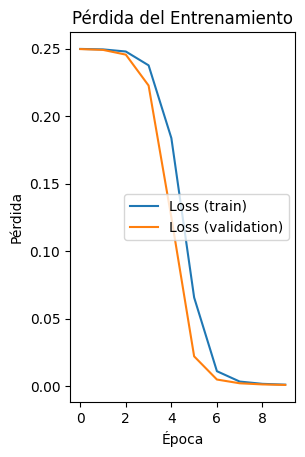

In [10]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Pérdida del Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [11]:
#arquitectura del modelo
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2455)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,514,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 25)                  │           6,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2455)                │       2,516,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,072,274 (72.75 MB)

 Trainable params: 6,357,424 (24.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,714,850 (48.50 MB)

In [12]:
# Modelo codificador
encoder_model = Model(inputs=input_layer, outputs=encoder_output)

# Obtener la representación comprimida de los datos
df_fX_compressed = encoder_model.predict(df_fX_scaled)

# df_fX_compressed ahora tiene la dimensionalidad reducida (9319, 25)
print(df_fX_compressed.shape)

292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
(9319, 25)


In [13]:
print(df_fX_scaled.shape)
print(encoder_output.shape)
print(df_fY.shape)
print(df_fX_compressed.shape)

(9319, 2455)
(None, 25)
(9319,)
(9319, 25)


## **Regresión Logistica**

In [14]:
# Split entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_fX_compressed, df_fY, test_size=0.2, random_state=42)

In [22]:
# Instancia del modelo
model = LogisticRegression()

# Entrena el modelo
model.fit(X_train, y_train)

# predicciones
y_pred = model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


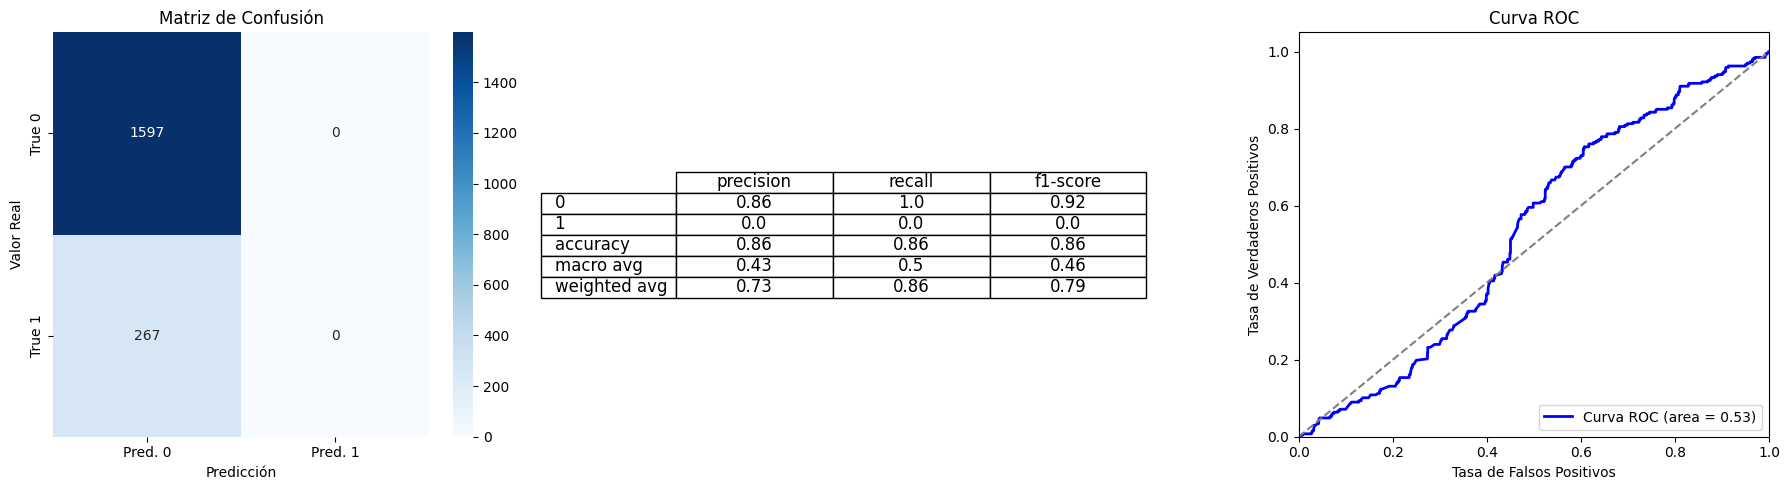

In [23]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Métricas de rendimiento
report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).transpose()[['precision', 'recall', 'f1-score']].round(2)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

# Crear subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))  # Tres subplots en una fila

# Graficar matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred. 0', 'Pred. 1'], yticklabels=['True 0', 'True 1'], ax=ax1)
ax1.set_title("Matriz de Confusión")
ax1.set_xlabel("Predicción")
ax1.set_ylabel("Valor Real")

# Tabla de métricas
ax2.axis('off')  # Desactivar los ejes para la tabla
table = ax2.table(cellText=metrics_df.values, colLabels=metrics_df.columns, rowLabels=metrics_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.2)  # Tamaño de la tabla

# Graficar curva ROC
ax3.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Tasa de Falsos Positivos')
ax3.set_ylabel('Tasa de Verdaderos Positivos')
ax3.set_title('Curva ROC')
ax3.legend(loc="lower right")

plt.tight_layout()
plt.show()

Ahora hago un sobremuestreo para balancear mis datos para las etiqueta menos frecuente

In [24]:
# Instancia de SMOTE
smote = SMOTE(random_state=42)

# Instancia el modelo de regresión logística
model2 = LogisticRegression()

# Ajustar los datos
X_res, y_res = smote.fit_resample(X_train, y_train)

# Entrena el modelo
model2.fit(X_res, y_res)

# predicciones
y_pred2 = model2.predict(X_test)

fpr2, tpr2, _ = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
roc_auc2 = roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

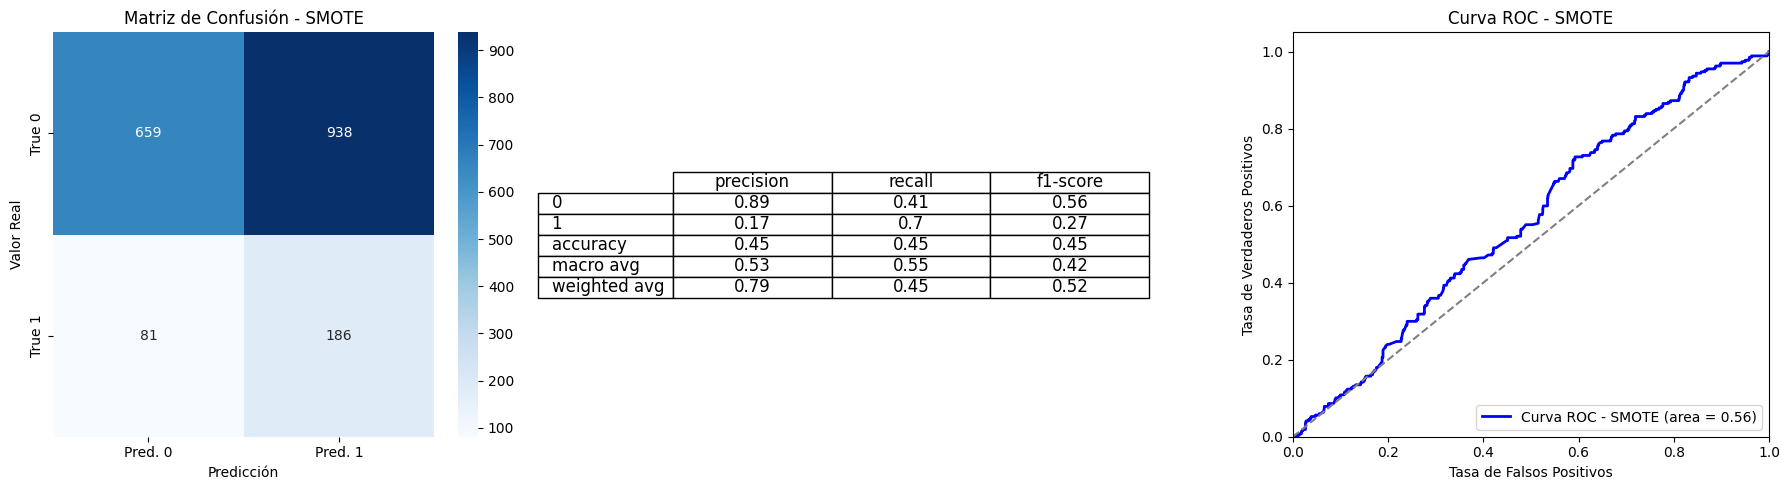

In [26]:
# Matriz de confusión
conf_matrix2 = confusion_matrix(y_test, y_pred2)

# Métricas de rendimiento
report2 = classification_report(y_test, y_pred2, output_dict=True)
metrics_df2 = pd.DataFrame(report2).transpose()[['precision', 'recall', 'f1-score']].round(2)

# Calcular curva ROC
fpr2, tp2, _ = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
roc_auc2 = roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

# Crear subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))  # Tres subplots en una fila

# Graficar matriz de confusión
sns.heatmap(conf_matrix2, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred. 0', 'Pred. 1'], yticklabels=['True 0', 'True 1'], ax=ax1)
ax1.set_title("Matriz de Confusión - SMOTE")
ax1.set_xlabel("Predicción")
ax1.set_ylabel("Valor Real")

# Tabla de métricas
ax2.axis('off')  # Desactivar los ejes para la tabla
table2 = ax2.table(cellText=metrics_df2.values, colLabels=metrics_df2.columns, rowLabels=metrics_df2.index, cellLoc='center', loc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(12)
table2.scale(1, 1.2)  # Tamaño de la tabla

# Graficar curva ROC
ax3.plot(fpr2, tpr2, color='blue', lw=2, label='Curva ROC - SMOTE (area = %0.2f)' % roc_auc2)
ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Tasa de Falsos Positivos')
ax3.set_ylabel('Tasa de Verdaderos Positivos')
ax3.set_title('Curva ROC - SMOTE')
ax3.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [44]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.89      0.41      0.56      1597
           1       0.17      0.70      0.27       267

    accuracy                           0.45      1864
   macro avg       0.53      0.55      0.42      1864
weighted avg       0.79      0.45      0.52      1864



In [42]:
# probabilidades para la clase 1
probabilidades_clase_1 = model2.predict_proba(X_test)[:, 1]

# Ajustar el umbral de decisión
umbral = 0.4
y_pred_ajustado = (probabilidades_clase_1 >= umbral).astype(int)

# Evaluar el rendimiento del modelo
print(classification_report(y_test, y_pred_ajustado))

# Calcular la curva ROC
fpr3, tpr3, _ = roc_curve(y_test, probabilidades_clase_1)
roc_auc3 = roc_auc_score(y_test, probabilidades_clase_1)

              precision    recall  f1-score   support

           0       0.94      0.03      0.05      1597
           1       0.15      0.99      0.25       267

    accuracy                           0.17      1864
   macro avg       0.54      0.51      0.15      1864
weighted avg       0.82      0.17      0.08      1864



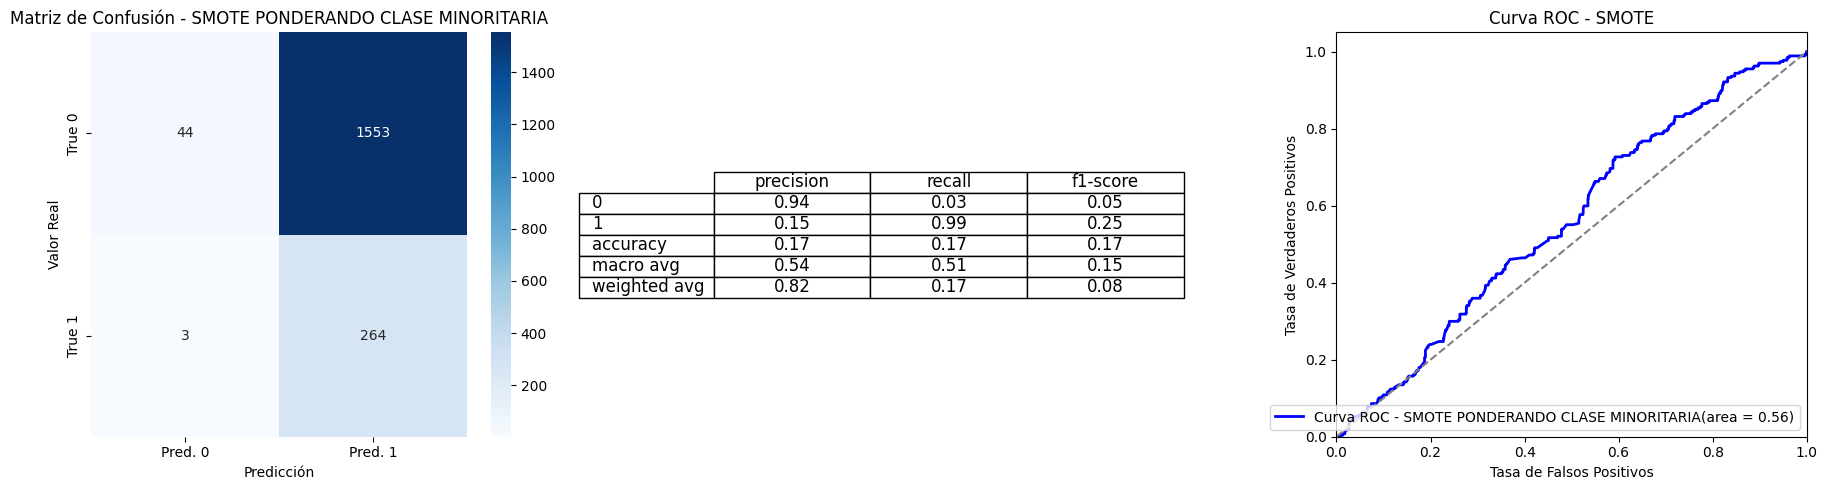

In [43]:
# Matriz de confusión
conf_matrix3 = confusion_matrix(y_test, y_pred_ajustado)

# Métricas de rendimiento
report3 = classification_report(y_test, y_pred_ajustado, output_dict=True)
metrics_df3 = pd.DataFrame(report3).transpose()[['precision', 'recall', 'f1-score']].round(2)

# Crear subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))  # Tres subplots en una fila

# Graficar matriz de confusión
sns.heatmap(conf_matrix3, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred. 0', 'Pred. 1'], yticklabels=['True 0', 'True 1'], ax=ax1)
ax1.set_title("Matriz de Confusión - SMOTE PONDERANDO CLASE MINORITARIA")
ax1.set_xlabel("Predicción")
ax1.set_ylabel("Valor Real")

# Tabla de métricas
ax2.axis('off')  # Desactivar los ejes para la tabla
table3 = ax2.table(cellText=metrics_df3.values, colLabels=metrics_df3.columns, rowLabels=metrics_df3.index, cellLoc='center', loc='center')
table3.auto_set_font_size(False)
table3.set_fontsize(12)
table3.scale(1, 1.2)  # Tamaño de la tabla

# Graficar curva ROC
ax3.plot(fpr3, tpr3, color='blue', lw=2, label='Curva ROC - SMOTE PONDERANDO CLASE MINORITARIA(area = %0.2f)' % roc_auc3)
ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Tasa de Falsos Positivos')
ax3.set_ylabel('Tasa de Verdaderos Positivos')
ax3.set_title('Curva ROC - SMOTE')
ax3.legend(loc="lower right")

plt.tight_layout()
plt.show()


Ahora genero regresion logistica con distintos hperparametros

In [47]:
# hiperparámetros a probar
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    'class_weight': [{0: 1, 1: 6},{0: 1, 1: 5},{0: 1, 1: 7}, {0: 1, 1: 10}, 'balanced']
}

# Instancia del modelo de regresión logística
model4 = LogisticRegression()

# Instancia de GridSearchCV
grid_search = GridSearchCV(model4, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Mejor hiperparámetro
print(f'Best parameters: {grid_search.best_params_}')

# Evaluar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Predicciones con el mejor modelo
y_pred_best = grid_search.predict(X_test)

# Calcular la curva ROC y el AUC para el mejor modelo
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'C': 100, 'class_weight': {0: 1, 1: 10}}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


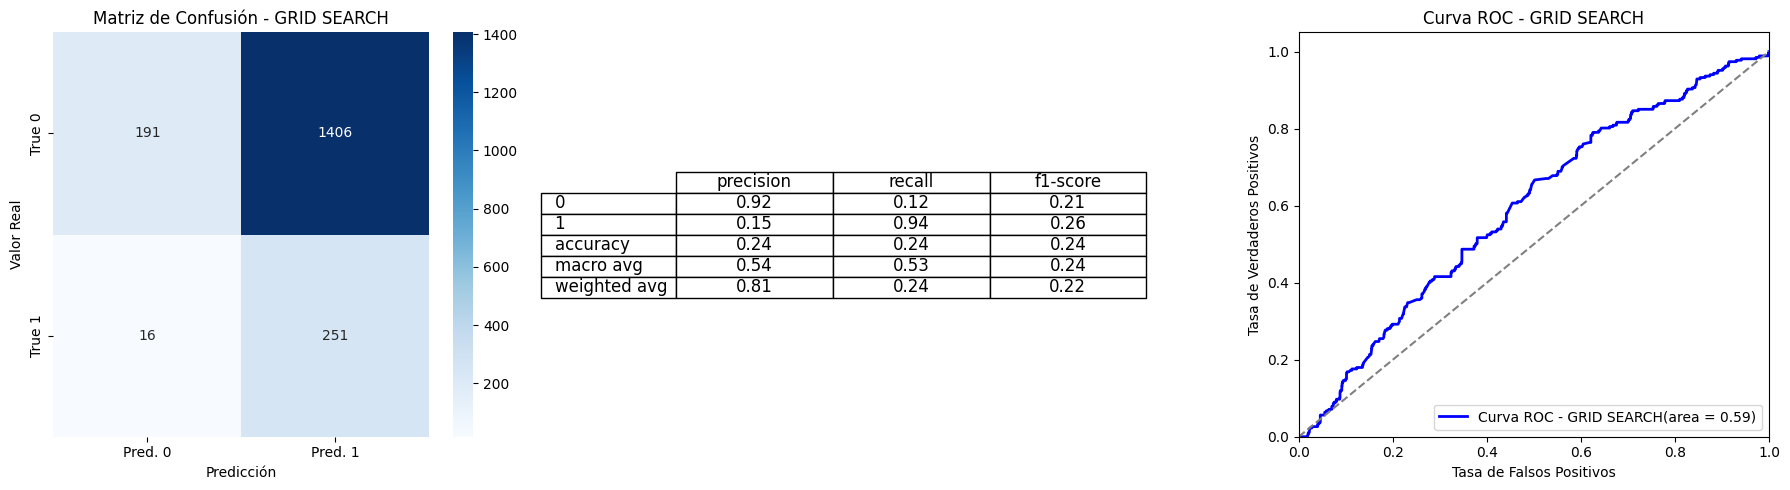

In [50]:
# Matriz de confusión
conf_matrix4 = confusion_matrix(y_test, y_pred_best)

# Métricas de rendimiento
report4 = classification_report(y_test, y_pred_best, output_dict=True)
metrics_df4 = pd.DataFrame(report4).transpose()[['precision', 'recall', 'f1-score']].round(2)

# Crear subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))  # Tres subplots en una fila

# Graficar matriz de confusión
sns.heatmap(conf_matrix4, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred. 0', 'Pred. 1'], yticklabels=['True 0', 'True 1'], ax=ax1)
ax1.set_title("Matriz de Confusión - GRID SEARCH")
ax1.set_xlabel("Predicción")
ax1.set_ylabel("Valor Real")

# Tabla de métricas
ax2.axis('off')  # Desactivar los ejes para la tabla
table4 = ax2.table(cellText=metrics_df4.values, colLabels=metrics_df4.columns, rowLabels=metrics_df4.index, cellLoc='center', loc='center')
table4.auto_set_font_size(False)
table4.set_fontsize(12)
table4.scale(1, 1.2)  # Tamaño de la tabla

# Graficar curva ROC
ax3.plot(fpr_best, tpr_best, color='blue', lw=2, label='Curva ROC - GRID SEARCH(area = %0.2f)' % roc_auc_best)
ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Tasa de Falsos Positivos')
ax3.set_ylabel('Tasa de Verdaderos Positivos')
ax3.set_title('Curva ROC - GRID SEARCH')
ax3.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [51]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.92      0.12      0.21      1597
           1       0.15      0.94      0.26       267

    accuracy                           0.24      1864
   macro avg       0.54      0.53      0.24      1864
weighted avg       0.81      0.24      0.22      1864



Conclusión - Como el objetivo es detectar fraudes, me quedo con el modelo 3, que es balanceado y ponderando la lcase minoritaria, pues tengo un recall del 99% lo que me indica que de 100 tickets fraudulentos, mi modelo dejará pasar uno.